In [1]:
import pandas as pd
import os
import csv
import ast
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_names = os.listdir('../../Preprocess/GadgetX-NewMDCLUSTER-1/combined-csv/')

In [3]:
dataframes = []
for file_name in file_names:
    df = pd.read_csv(f'../../Preprocess/GadgetX-NewMDCLUSTER-1/combined-csv/{file_name}')
    dataframes.append(df)

In [4]:
all_data = pd.concat(dataframes)

# Convert the 'ProgenitorsID' column from string to list
all_data['ProgenitorsID'] = all_data['ProgenitorsID'].apply(ast.literal_eval)

# Sort the snapshots in descending order
all_data = all_data.sort_values(by=['snapshot', 'ID'], ascending=[False, True])

In [5]:
training_data = pd.read_csv('../../Preprocess/GadgetX-NewMDCLUSTER-1/progenitor-pair/60 snapshots/training_data.csv')

In [6]:
training_data.head()

,hostHalo,numSubStruct,Mvir,npart,Xc,Yc,Zc,VXc,VYc,VZc,...,progenitor_Phi0,progenitor_cNFW,progenitor_ID,progenitor_numProgenitors,progenitor_ProgenitorsID,progenitor_redshift,progenitor_snapshot,rel_location,rel_velocity,Is_Progenitor
0,0,0,8.208870e+10,107,478974.960199,497094.870341,479319.813775,259.33,-257.73,435.64,...,59766.7,8.22110,59000000003585,1,[58000000003608],3.602,59,90.732009,11.887834,1
1,0,1,1.381390e+12,2121,501494.974173,503241.347716,506216.618465,-167.89,-121.54,-564.61,...,27092.7,8.28377,59000000012729,1,[57000000013857],3.602,59,3117.367968,280.693017,0
2,0,1,2.645330e+11,324,513435.329710,489948.246096,482974.115227,-179.09,233.46,79.34,...,34060.8,-1.00000,55000000007656,1,[54000000007596],4.018,55,83.493853,191.842340,1
3,0,0,2.765760e+10,34,502363.051917,504874.587059,519868.178948,25.30,-232.56,-440.75,...,23492.3,4.49256,58000000010058,1,[57000000010565],3.711,58,88.608087,7.679772,1
4,0,0,4.439610e+11,783,499722.673736,491266.214185,505454.872594,15.20,187.17,-168.36,...,53785.1,13.76350,59000000004971,1,[58000000004365],3.602,59,4510.402471,411.180679,0


In [7]:
features = ['rel_location', 'rel_velocity', 'Is_Progenitor', 'Mvir']

progenitor_features = ['progenitor_Mvir']

# Select only the defined features from the training data
training_data = training_data[features + progenitor_features]

training_data.head()


,rel_location,rel_velocity,Is_Progenitor,Mvir,progenitor_Mvir
0,90.732009,11.887834,1,8.208870e+10,7.084190e+10
1,3117.367968,280.693017,0,1.381390e+12,2.083940e+10
2,83.493853,191.842340,1,2.645330e+11,2.686110e+10
3,88.608087,7.679772,1,2.765760e+10,2.718500e+10
4,4510.402471,411.180679,0,4.439610e+11,5.460630e+10


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = training_data.drop('Is_Progenitor', axis=1)
y = training_data['Is_Progenitor']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import binarize

weights = {0: 1, 1: 20}
# Train the Random Forest model
model = RandomForestClassifier(class_weight=weights, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Change the threshold here
threshold = 0.5
y_pred = binarize(y_pred_prob.reshape(1, -1), threshold=threshold)[0]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40575
           1       1.00      1.00      1.00     40673

    accuracy                           1.00     81248
   macro avg       1.00      1.00      1.00     81248
weighted avg       1.00      1.00      1.00     81248



-------------------------------------------

# Functions

In [10]:
import warnings
warnings.filterwarnings('ignore')

def create_merger_tree(halo, model, scaler, all_data, threshold=0.5):
    
    merger_tree = [halo]
    
    features = ['rel_location', 'rel_velocity', 'Mvir']
    progenitor_features = ['progenitor_Mvir']

    # Get halos in previous snapshot
    previous_snapshot = halo['snapshot'] - 1
    previous_halos = all_data[all_data['snapshot'] == previous_snapshot]
    
    # For each halo in the previous snapshot, predict whether it will merge with the current halo
    for i, previous_halo in previous_halos.iterrows():
        # Create the feature vector for the current pair of halos
        pair = pd.concat([halo, previous_halo.rename(lambda x: f'progenitor_{x}')])

        # calculate relative location and velocity
        rel_location = 0
        rel_velocity = 0
        for dim, dim_c in zip(['X', 'Y', 'Z'], ['Xc', 'Yc', 'Zc']):
            rel_location += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
        for dim, dim_c in zip(['VX', 'VY', 'VZ'], ['VXc', 'VYc', 'VZc']):
            rel_velocity += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                
        # compute the square root to get the Euclidean distance
        pair['rel_location'] = np.sqrt(rel_location)
        pair['rel_velocity'] = np.sqrt(rel_velocity)

        feature_vector = pair[features + progenitor_features]
        feature_vector_scaled = scaler.transform(feature_vector.values.reshape(1, -1))
        
        # Use the model to predict the probability of the previous halo being a progenitor of the current halo
        pred_prob = model.predict_proba(feature_vector_scaled)[:, 1]
        
        # Apply the threshold to the predicted probabilities to make a final prediction
        prediction = binarize(pred_prob.reshape(1, -1), threshold=threshold)[0]
        
        # If the model predicts a merger, add the previous halo to the merger tree
        if prediction == 1:
            merger_tree.append(previous_halo)
            
            # Recursive call to find the progenitor's progenitor
            merger_tree += create_merger_tree(previous_halo, model, scaler, all_data, threshold)
                
    return merger_tree

def track_halo_history_predicted(halo, model, scaler, all_data):
    history = create_merger_tree(halo, model, scaler, all_data)
    return pd.DataFrame(history)

def track_halo_history_real(halo_id, snapshot, df):
    halo = df[(df['ID'] == halo_id) & (df['snapshot'] == snapshot)]
    if len(halo) == 0:
        return pd.DataFrame()
    progenitors = halo.iloc[0]['ProgenitorsID']
    history = halo
    if progenitors:
        for progenitor in progenitors:
            if progenitor == -1:  # Ignore the progenitor if its ID is -1
                continue
            progenitor_history = track_halo_history_real(progenitor, snapshot - 1, df)
            history = pd.concat([history, progenitor_history])
    return history


def plot_halo_history(halo_id, real_halo_history, predicted_halo_history, title):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    id_to_point_real = {row['ID']: (row['redshift'], row['Mvir'] / 1e11) for _, row in real_halo_history.iterrows()}
    id_to_point_predicted = {row['ID']: (row['redshift'], row['Mvir'] / 1e11) for _, row in predicted_halo_history.iterrows()}

    real_progenitors = {row['ID']: set(row['ProgenitorsID']) for _, row in real_halo_history.iterrows()}
    predicted_progenitors = {row['ID']: set(row['ProgenitorsID']) for _, row in predicted_halo_history.iterrows()}

    # Set the font dictionaries (for title and labels)
    font_title = {'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 16}
    font_axes = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 14}
    font_legend = {'size': 12}

    # Plot the real history first
    for id_to_point, halo_history, color, line_style, label in [(id_to_point_real, real_halo_history, 'red', '-', 'False Negative')]:
        for group_id, group in halo_history.groupby('ID'):
            for _, row in group.iterrows():
                for progenitor in row['ProgenitorsID']:
                    if progenitor == -1 or progenitor not in id_to_point:
                        continue
                    x_values = [id_to_point[group_id][0], id_to_point[progenitor][0]]
                    y_values = [id_to_point[group_id][1], id_to_point[progenitor][1]]
                    ax1.plot(x_values, y_values, line_style, color=color, alpha=0.7)

        for group_id, group in halo_history.groupby('ID'):
            for _, row in group.iterrows():
                point_color = 'orange' if row['ID'] == halo_id else color
                markersize = 12 if row['ID'] == halo_id else None
                ax1.plot(row['redshift'], row['Mvir'] / 1e11, 'o', linestyle=line_style, color=point_color, markersize=markersize)

    # Plot the predicted history after the real history
    for id_to_point, halo_history, color, line_style, label in [(id_to_point_predicted, predicted_halo_history, 'green', ' ', 'Predicted')]:
        for group_id, group in halo_history.groupby('ID'):
            for _, row in group.iterrows():
                for progenitor in row['ProgenitorsID']:
                    if progenitor == -1 or progenitor not in id_to_point:
                        continue
                    x_values = [id_to_point[group_id][0], id_to_point[progenitor][0]]
                    y_values = [id_to_point[group_id][1], id_to_point[progenitor][1]]
                    real_pred = real_progenitors.get(row['ID'], set())
                    predicted_pred = predicted_progenitors.get(row['ID'], set())
                    if progenitor in real_pred and progenitor in predicted_pred: # True positive
                        line_color = 'green'
                    elif progenitor not in real_pred and progenitor in predicted_pred: # False positive
                        line_color = 'blue'
                    else:
                        line_color = color
                    ax1.plot(x_values, y_values, color=line_color, alpha=1)

        for group_id, group in halo_history.groupby('ID'):
            for _, row in group.iterrows():
                correct = real_progenitors.get(row['ID'], set()) == predicted_progenitors.get(row['ID'], set())
                point_color = 'orange' if row['ID'] == halo_id else ('green' if correct else 'blue')
                markersize = 12 if row['ID'] == halo_id else None
                ax1.plot(row['redshift'], row['Mvir'] / 1e11, 'o', linestyle=line_style, color=point_color, markersize=markersize)

    # Add a separate plot for the final halo legend
    ax1.plot([], [], 'o', color='orange', label='Final Halo')
    # Reorder the labels
    ax1.plot([], [], 'o', linestyle=' ', color='green', label='True Positive')
    ax1.plot([], [], 'o', linestyle=' ', color='blue', label='False Positive')
    ax1.plot([], [], 'o', linestyle=' ', color='red', label='False Negative')

    # Set the axes labels
    ax1.set_xlabel('Redshift', fontdict=font_axes)
    ax1.set_ylabel(r'$M_{\mathrm{vir}} \, / \, 10^{11} M_{\odot}$', fontdict=font_axes)  # Use LaTeX for the y-label
    # Set the title with increased padding
    plt.title(title, fontdict=font_title, pad=0)
    # Set the legend
    ax1.legend(fontsize=font_legend['size'])
    # Reverse the x-axis
    plt.gca().invert_xaxis()
    # Show the plot
    plt.show()


def plot_halo_history_separate(halo_id, halo_history, title, subplot=None,line_color='red'):
    if subplot is not None:
        plt.subplot(*subplot)

    id_to_point = {row['ID']: (row['redshift'], row['Mvir']) for _, row in halo_history.iterrows()}

    for _, row in halo_history.iterrows():
        for progenitor in row['ProgenitorsID']:
            if progenitor == -1 or progenitor not in id_to_point:
                continue
            x_values = [id_to_point[row['ID']][0], id_to_point[progenitor][0]]
            y_values = [id_to_point[row['ID']][1], id_to_point[progenitor][1]]
            plt.plot(x_values, y_values, color=line_color, alpha=0.3, linestyle='solid')

    for _, row in halo_history.iterrows():
        if row['ID'] == halo_id:
            point_color = 'orange'
            markersize = 20
            marker = 'o'
        else:
            point_color = line_color
            markersize = 8
            marker = 'o'
        plt.plot(row['redshift'], row['Mvir'], marker, color=point_color, markersize=markersize, alpha=0.7)

    plt.xlabel('Redshift', fontsize=14)
    plt.ylabel('Mvir', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_xaxis()
    
def plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history):
    plt.figure(figsize=(20, 8))
    plot_halo_history_separate(halo_id, real_halo_history, 'AHF Merger History', subplot=(1, 2, 1), line_color='green')
    plot_halo_history_separate(halo_id, predicted_halo_history, 'Predicted Halo Merger History', subplot=(1, 2, 2), line_color='blue')
    plt.tight_layout()
    plt.show()



-----------------------------------

# Testing

In [11]:
new_file_names = os.listdir('../../Preprocess/GadgetX-NewMDCLUSTER-2/combined-csv/')

dataframes = []
for new_file_names in new_file_names:
    df = pd.read_csv(f'../../Preprocess/GadgetX-NewMDCLUSTER-2/combined-csv/{new_file_names}')
    dataframes.append(df)

new_data = pd.concat(dataframes)

new_data['ProgenitorsID'] = new_data['ProgenitorsID'].apply(ast.literal_eval)

new_data = new_data.sort_values(by=['snapshot', 'ID'], ascending=[False, True])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184031
           1       1.00      1.00      1.00    184031

    accuracy                           1.00    368062
   macro avg       1.00      1.00      1.00    368062
weighted avg       1.00      1.00      1.00    368062



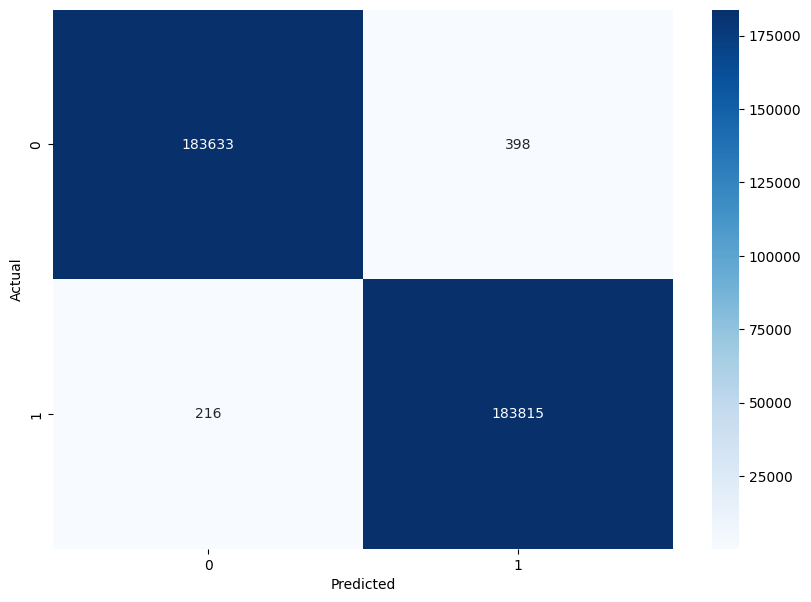

Accuracy:  0.9983318027940945


In [12]:
testing_data = pd.read_csv('../../Preprocess/GadgetX-NewMDCLUSTER-2/progenitor-pair/testing_data.csv')
testing_data = testing_data[features + progenitor_features]
X_new = testing_data.drop('Is_Progenitor', axis=1)
y_new = testing_data['Is_Progenitor']
X_new_scaled = scaler.transform(X_new)
y_new_pred_prob = model.predict_proba(X_new_scaled)[:, 1]
y_new_pred = binarize(y_new_pred_prob.reshape(1, -1), threshold=threshold)[0]
print(classification_report(y_new, y_new_pred))
cm = confusion_matrix(y_new, y_new_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

accuracy = accuracy_score(y_new, y_new_pred)
print('Accuracy: ', accuracy)

---------

# Merger Trees

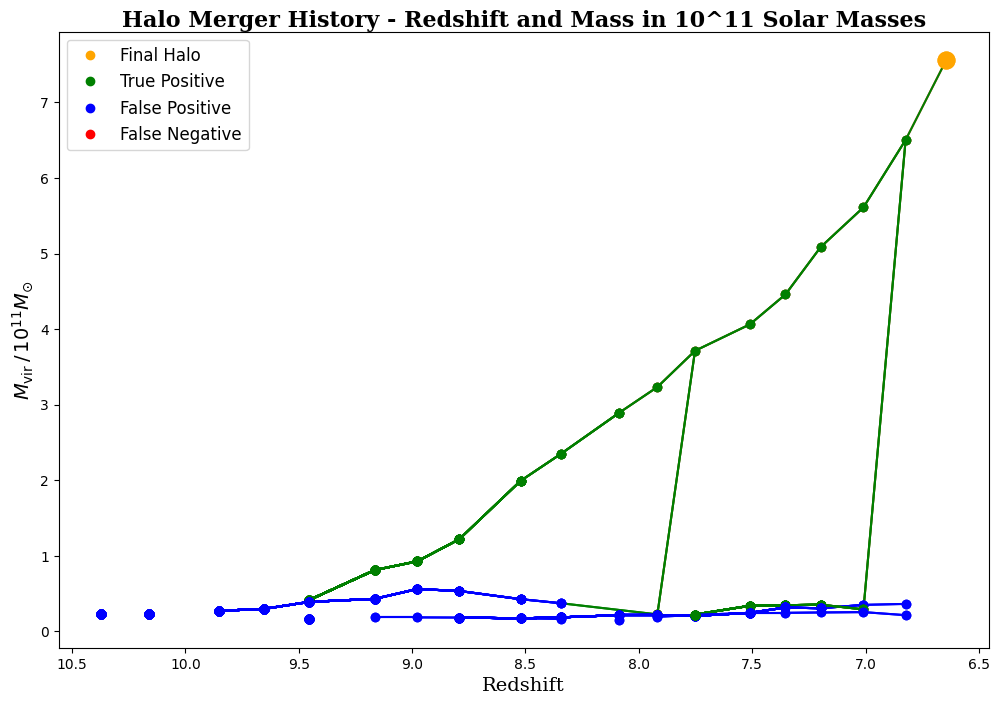

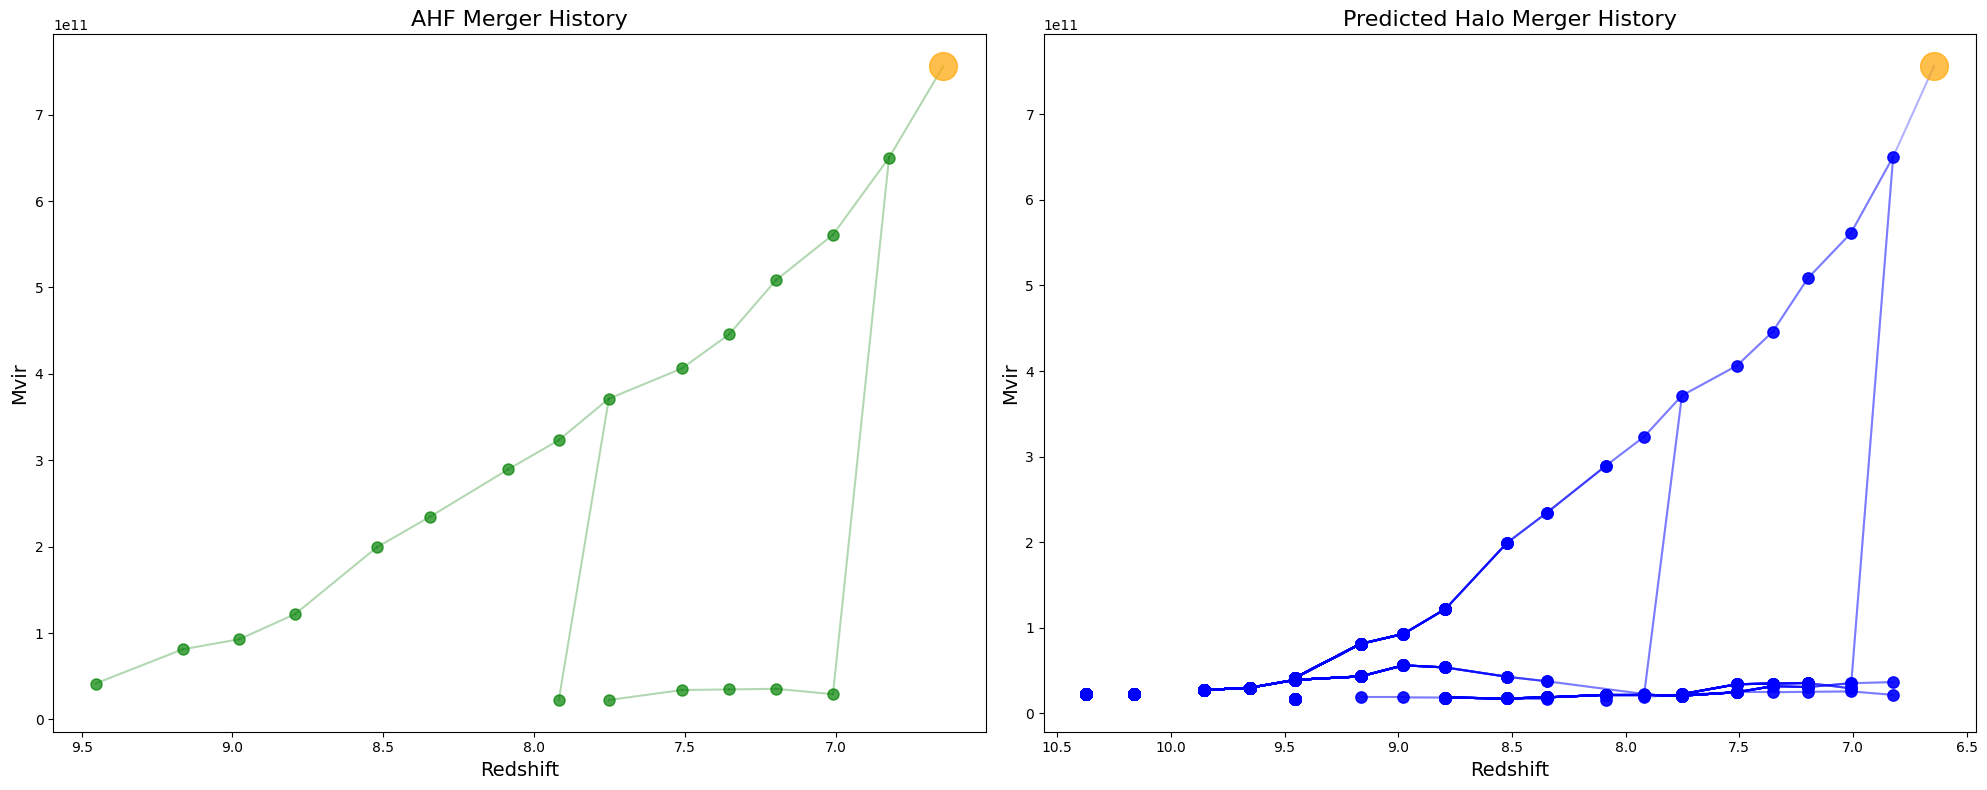

In [13]:
halo = new_data[new_data['ID'] == 36000000000001].iloc[-1] 
halo_id = 36000000000001
snapshot = 36
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)

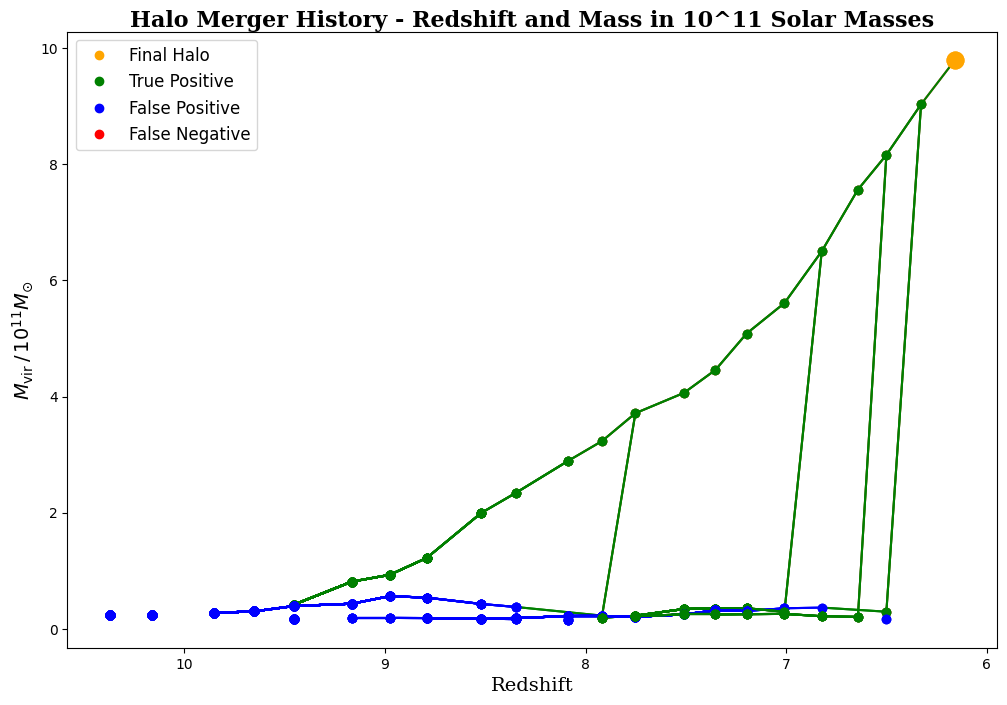

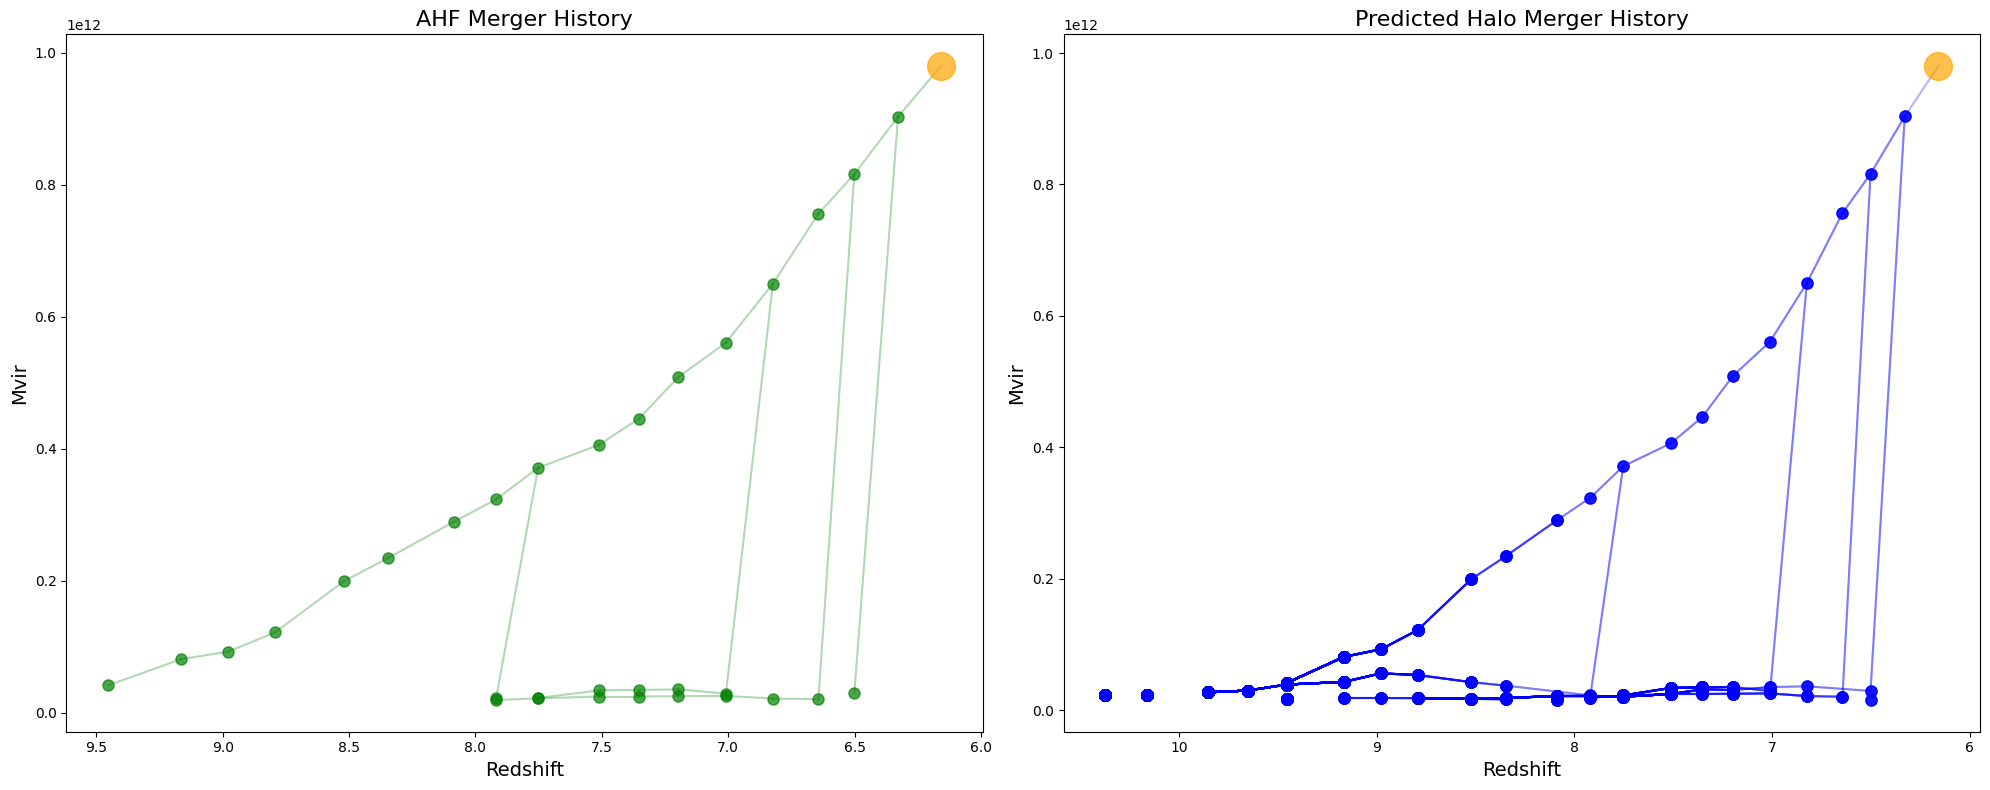

In [14]:
halo = new_data[new_data['ID'] == 39000000000001].iloc[-1] 
halo_id = 39000000000001
snapshot = 39
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)

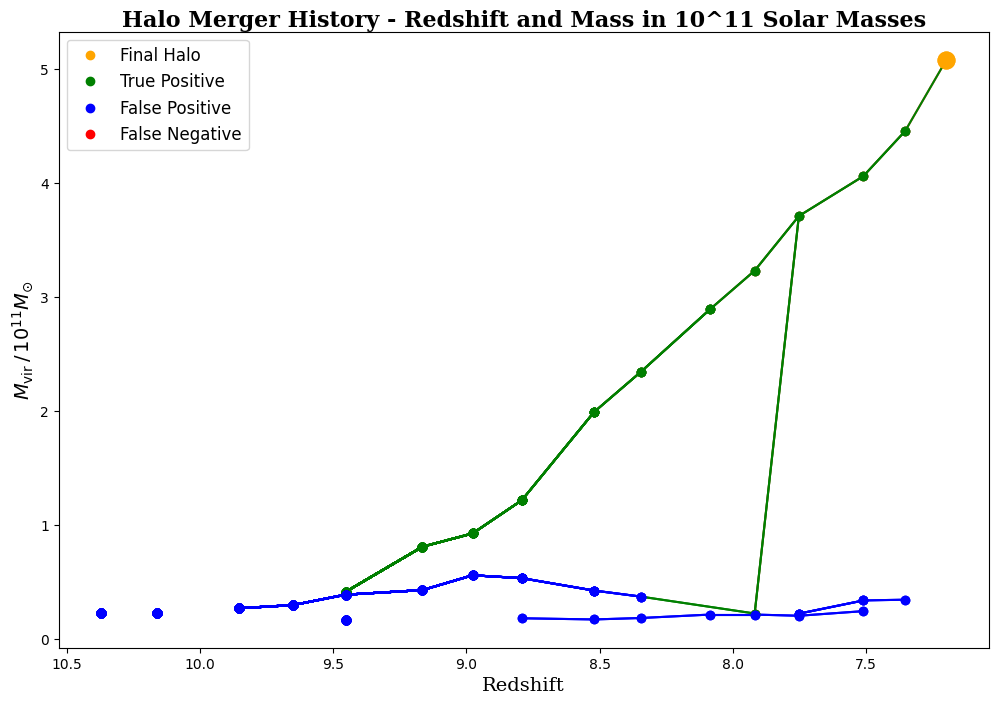

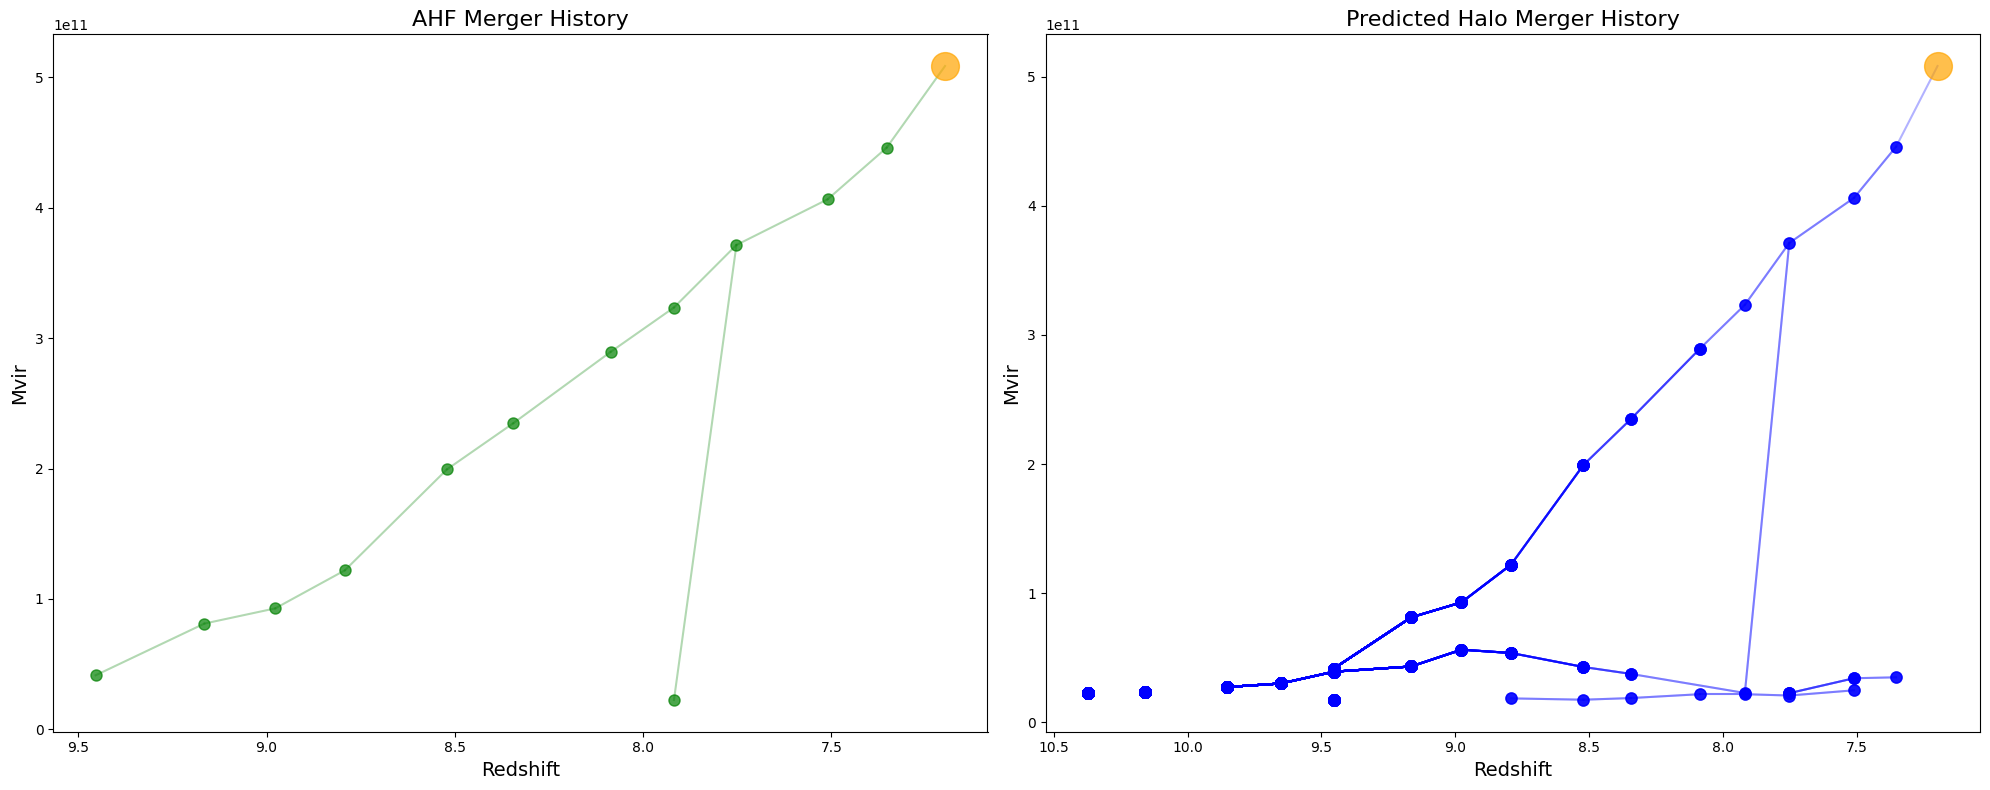

In [15]:
halo = new_data[new_data['ID'] == 33000000000001].iloc[-1] 
halo_id = 33000000000001
snapshot = 33
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)

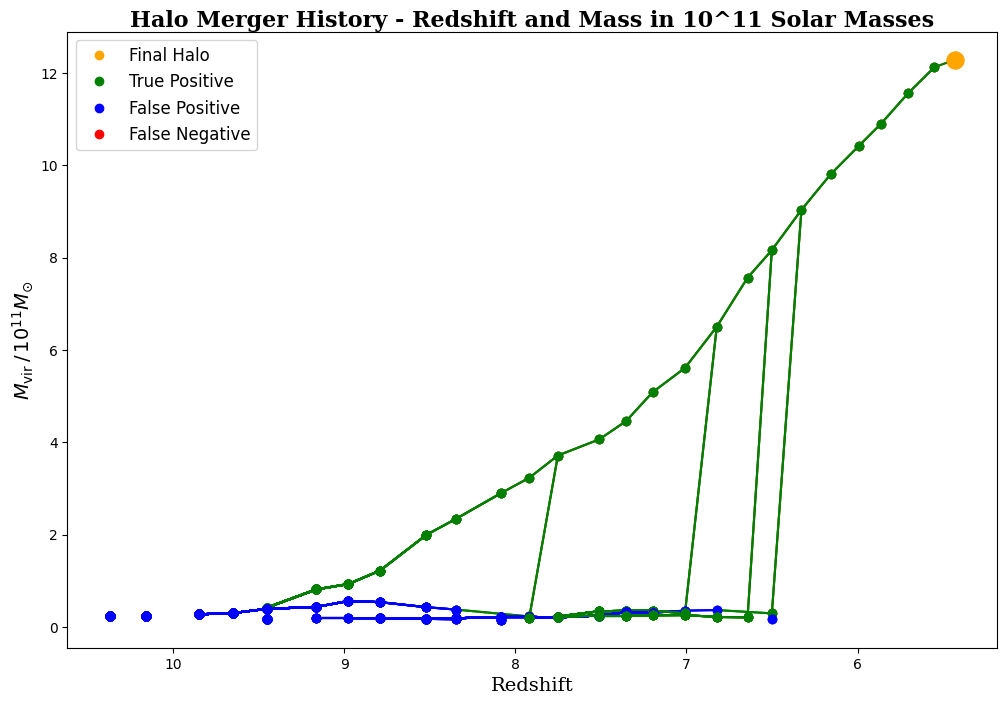

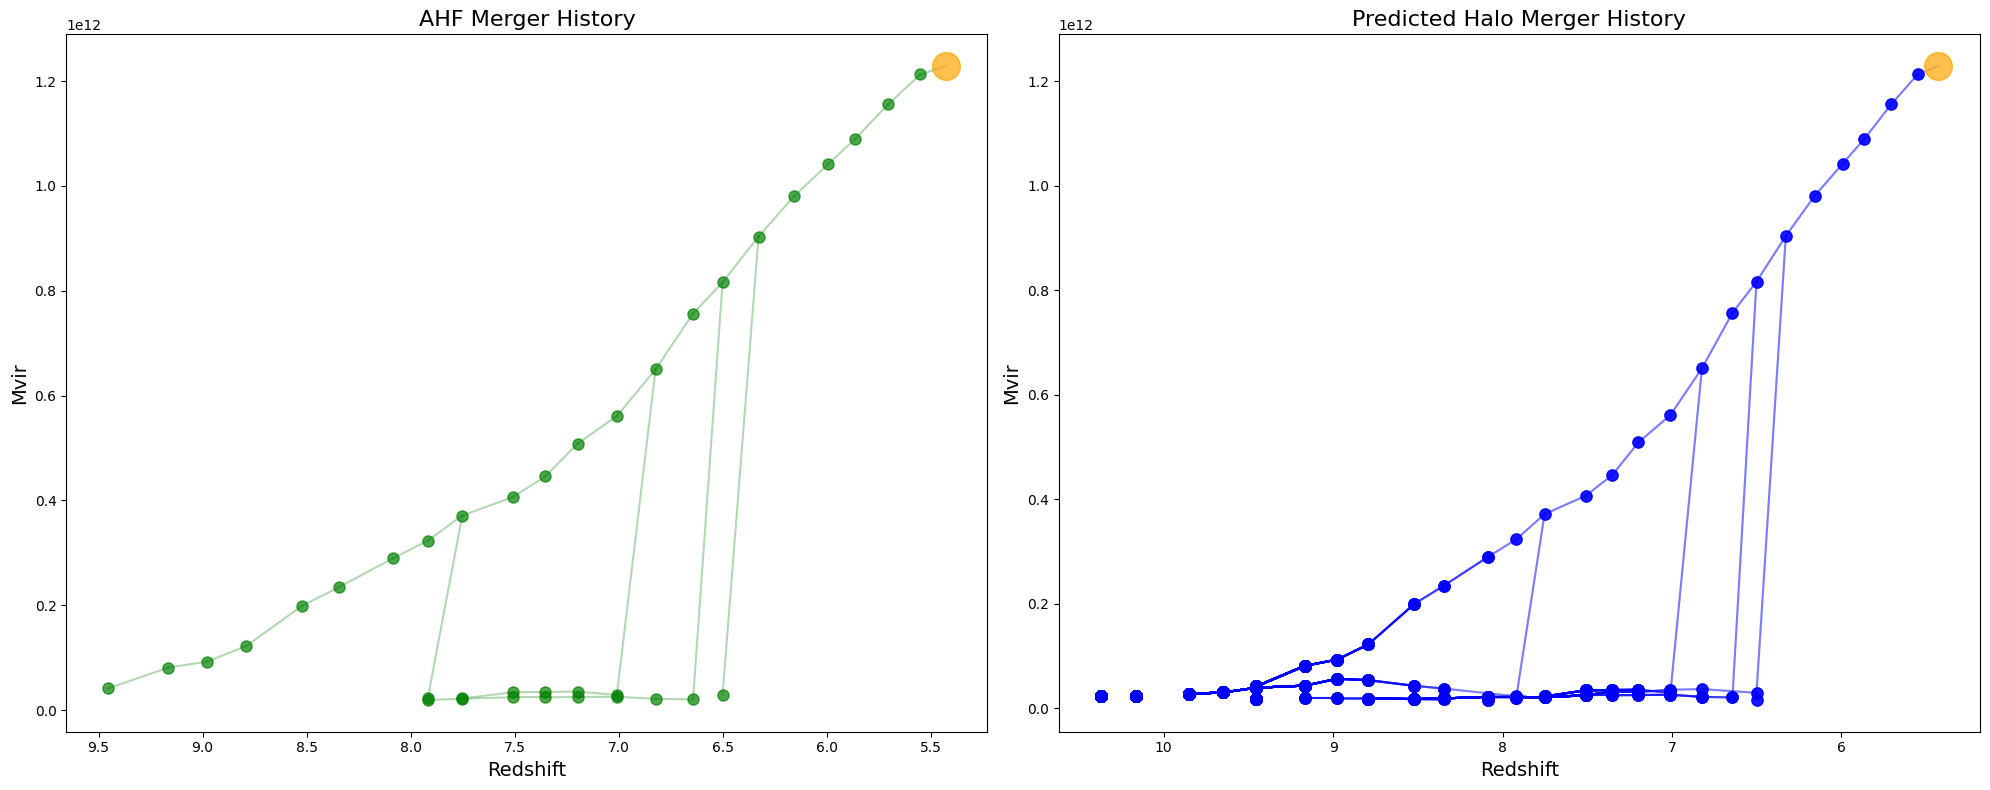

In [16]:
halo = new_data[new_data['ID'] == 44000000000001].iloc[-1] 
halo_id = 44000000000001
snapshot = 44
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)